In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### Inception Blocks

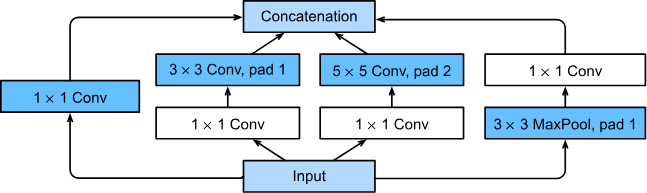

In [3]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

To gain some intuition for why this network works so well, consider the combination of the filters. They explore the image in a variety of filter sizes. This means that details at different extents can be recognized efficiently by filters of different sizes. At the same time, we can allocate different amounts of parameters for different filters.

### GoogLeNet Model

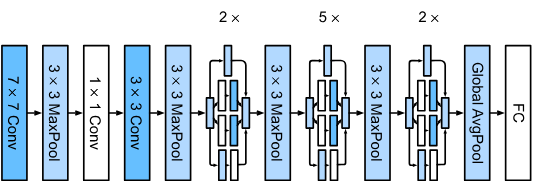

In [9]:
class GoogleNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super(GoogleNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                                self.b5(), nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                            Inception(128, (128, 192), (32, 96), 64),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def b4(self):
        return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                            Inception(160, (112, 224), (24, 64), 64),
                            Inception(128, (128, 256), (24, 64), 64),
                            Inception(112, (144, 288), (32, 64), 64),
                            Inception(256, (160, 320), (32, 128), 128),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b5(self):
        return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                            Inception(384, (192, 384), (48, 128), 128),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [16]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### Training

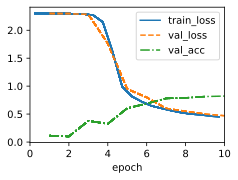

In [17]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)